In [158]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3
import pandas as pd
sess = sagemaker.Session()
import matplotlib.pyplot as plt
import seaborn as sns
role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = 'qanv-aws-1' #sess.default_bucket() # Replace with your own bucket name if needed
print(bucket)
#prefix = 'blazingtext/supervised' #Replace with the prefix under which you want to store the data if needed
prefix = 'nlp/unsupervised' #Replace with the prefix under which you want to store the data if needed

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20181029T121824
qanv-aws-1


In [122]:
!pwd

/home/ec2-user/SageMaker/aws-ml-nlp


In [2]:
!wget https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz

--2019-03-13 00:46:13--  https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.233.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.233.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688339454 (656M) [application/x-tar]
Saving to: ‘amazon_review_polarity_csv.tgz.1’

amazon_review_polar 100%[===================>] 656.45M  48.1MB/s    in 13s     

2019-03-13 00:46:26 (49.7 MB/s) - ‘amazon_review_polarity_csv.tgz.1’ saved [688339454/688339454]



In [3]:
 
!tar -xvzf amazon_review_polarity_csv.tgz
#df = pd.read_csv("amazon_review_polarity_csv/train.csv", names=["Label", "Title", "Review"])

amazon_review_polarity_csv/
amazon_review_polarity_csv/train.csv
amazon_review_polarity_csv/readme.txt
amazon_review_polarity_csv/test.csv


In [4]:
test_df = pd.read_csv("/home/ec2-user/SageMaker/amazon_review_polarity_csv/test.csv", names=["Label", "Title", "Review"])


In [3]:
test_df.Label.value_counts()

2    200000
1    200000
Name: Label, dtype: int64

In [4]:
test_df.dtypes

Label      int64
Title     object
Review    object
dtype: object

In [5]:
test_df.sample(10)


,Label,Title,Review
149518,1,Poor Gilbert :-(,Poor Gilbert! He must have turned over in his ...
90156,1,too much of bad things can't be good,Usually I am able to fly through books by Larr...
32609,2,This is one nice cd.,Nas has done it again. This cd is all that. It...
175748,1,dont buy,This is trash I dont know who rates this devic...
221435,1,Not for technical use.,"If you want read guitar amp appreciation, this..."
316393,2,Written from the heart...,Mr. Sapoznik not only does an enviable job of ...
175026,1,Functional but not made to withstand travel,Its silly that this bag is so flimsy and not m...
309768,1,One of the worst....,I like her aerobics classes on TV but this boo...
71884,2,The Beasties have done it again!,"Wow, what a good CD! I really like the Beastie..."
143618,1,Sorry I bought it -- a one-time read at most,I saw several good reviews of this book but I ...


In [5]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
index_to_label = {'1': 'Negative', '2': 'Positive'}

In [7]:
def transform_instance(row):
    cur_row = []
    #label = "__label__" + index_to_label[row[0]]  #Prefix the index-ed label with __label__
    #cur_row.append(label)
    cur_row.extend(nltk.word_tokenize(row[1].lower()))
    cur_row.extend(nltk.word_tokenize(row[2].lower()))
    return cur_row

In [8]:
def preprocess(input_file, output_file, keep=1):
    all_rows = []
    with open(input_file, 'r') as csvinfile:
        csv_reader = csv.reader(csvinfile, delimiter=',')
        for row in csv_reader:
            all_rows.append(row)
    shuffle(all_rows)
    all_rows = all_rows[:int(keep*len(all_rows))]
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(transform_instance, all_rows)
    pool.close() 
    pool.join()
    
    with open(output_file, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=' ', lineterminator='\n')
        csv_writer.writerows(transformed_rows)

In [ ]:
%%timeit
# Preparing the training dataset

# Since preprocessing the whole dataset might take a couple of mintutes,
# we keep 20% of the training dataset for this demo.
# Set keep to 1 if you want to use the complete dataset
preprocess('/home/ec2-user/SageMaker/amazon_review_polarity_csv/train.csv', 'polarity_un.train', keep=.2)
        
# Preparing the validation dataset        
preprocess('/home/ec2-user/SageMaker/amazon_review_polarity_csv/test.csv', 'polarity_un.validation')

In [12]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path='polarity_un.train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='polarity_un.validation', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

CPU times: user 4.05 s, sys: 1.2 s, total: 5.25 s
Wall time: 8.21 s


In [13]:
region_name = boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))


Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [15]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         base_job_name = 'qanv',
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)
bt_model.set_hyperparameters(mode="cbow",
                            epochs=10,
                            min_count=2,
                            learning_rate=0.05,
                            sampling_threshold=0.0001,
                            vector_dim=100,
                            negative_samples=5,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5)

In [16]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

In [17]:
bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: qanv-2019-03-13-16-48-02-211


2019-03-13 16:48:02 Starting - Starting the training job...
2019-03-13 16:48:03 Starting - Launching requested ML instances......
2019-03-13 16:49:08 Starting - Preparing the instances for training...
2019-03-13 16:49:58 Downloading - Downloading input data
2019-03-13 16:49:58 Training - Training image download completed. Training in progress.....
Arguments: train
[03/13/2019 16:49:58 WARNING 139967447238464] Loggers have already been setup.
[03/13/2019 16:49:58 WARNING 139967447238464] Loggers have already been setup.
[03/13/2019 16:49:58 INFO 139967447238464] nvidia-smi took: 0.025171995163 secs to identify 0 gpus
[03/13/2019 16:49:58 INFO 139967447238464] Running single machine CPU BlazingText training using cbow mode.
[03/13/2019 16:49:58 INFO 139967447238464] Processing /opt/ml/input/data/train/polarity_un.train . File size: 304 MB
[03/13/2019 16:49:58 INFO 139967447238464] Processing /opt/ml/input/data/validation/polarity_un.validation . File size: 169 MB
Read 10M words
Read 20M 

In [18]:
text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: blazingtext-2019-03-13-17-28-37-472
INFO:sagemaker:Creating endpoint with name qanv-2019-03-13-16-48-02-211


---------------------------------------------------------------------------!

In [36]:
words = ["horrrrible", "trash"]

payload = {"instances" : words}
response = text_classifier.predict(json.dumps(payload))

vecs = json.loads(response)
print(vecs)

[{'vector': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'word': 'horrrrible'}, {'vector': [2.2700140476226807, 0.6127733588218689, -0.48993268609046936, -0.014852423220872879, 1.1655844449996948, -1.9192851781845093, -1.2825520038604736, 1.6169021129608154, -2.3218791484832764, -1.2199220657348633, -1.3224515914916992, -1.4580748081207275, 0.4723014235496521, 1.117205023765564, 0.22182601690292358, -1.0629606246948242, 3.4273619651794434, -2.3054604530334473, 0.8330034613609314, -1.7547646760940552, 3.6889243125915527, 0.403549194335937

In [24]:
len(vecs)

1

In [ ]:
#sess.delete_endpoint(text_classifier.endpoint)

In [29]:
s3 = boto3.resource('s3')

key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
s3.Bucket(bucket).download_file(key, 'model.tar.gz')

In [30]:
!tar -xvzf model.tar.gz


vectors.bin
vectors.txt
eval.json


In [31]:
!cat eval.json

{
    "EN-WS-353-ALL.txt": {
        "not_found": 2, 
        "spearmans_rho": 0.5795943981067397, 
        "total_pairs": 353
    }, 
    "EN-WS-353-REL.txt": {
        "not_found": 1, 
        "spearmans_rho": 0.5222618744822383, 
        "total_pairs": 252
    }, 
    "EN-WS-353-SIM.txt": {
        "not_found": 1, 
        "spearmans_rho": 0.6666242012029381, 
        "total_pairs": 203
    }, 
    "mean_rho": 0.589493491263972
}

In [33]:
!tail vectors.txt

'transfer 0.062377 -0.10936 -0.12911 -0.11181 -0.11554 0.1634 -0.23542 0.046187 -0.065376 -0.12088 -0.076733 -0.03615 -0.088259 0.13347 -0.20051 0.21715 -0.038717 -0.12783 -0.059941 -0.1095 0.076013 0.20342 -0.056472 0.00072833 -0.14937 0.060273 0.11839 -0.065265 -0.21392 -0.030054 0.0033082 0.094757 0.13524 -0.042168 -0.25884 -0.0055309 0.033899 -0.065565 -0.094133 0.0097037 -0.025183 0.082376 0.082879 -0.0093927 0.097018 -0.15122 0.038692 -0.18472 -0.078521 -0.033271 -0.12886 -0.088696 -0.11394 0.33585 0.17094 -0.10686 0.07123 0.031806 0.025187 0.11603 0.15862 -0.016338 0.33123 0.054597 0.21702 -0.083176 -0.15199 -0.00026778 -0.088092 -0.26373 -0.060427 -0.12375 -0.070398 0.0021898 -0.18187 -0.23028 0.16315 0.068779 0.34453 -0.016138 0.082578 -0.017507 -0.040703 -0.086547 0.11493 0.1013 0.1472 0.28237 -0.11882 0.13482 0.11589 -0.13882 0.19688 -0.17772 -0.13909 -0.13836 -0.21253 -0.0050515 0.08291 -0.13659 
damagingly 0.17294 0.25935 -0.055217 0.046135 0.15599 0.08519 -0.29102 0.19346

In [50]:
import numpy as np
from sklearn.preprocessing import normalize

# Read the 400 most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 100

first_line = True
index_to_word = []
with open("vectors.txt","r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num-1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
word_vecs = normalize(word_vecs, copy=False, return_norm=False)

In [44]:
word_vecs[0], index_to_word[399]

(array([-0.07267984, -0.14680937, -0.07477766, -0.22907323,  0.22092994,
        -0.28268857,  0.06015426,  0.02916117, -0.00247341, -0.00374694,
         0.15536174, -0.09997073,  0.18334552,  0.09008629, -0.04785111,
         0.01686186, -0.03044338, -0.01848157,  0.06127156,  0.02819088,
         0.03073997, -0.00971097,  0.02887609,  0.08180749, -0.11990454,
         0.10923772, -0.12248048, -0.06165891, -0.10581038, -0.01163161,
        -0.14738464, -0.04117923,  0.0807656 , -0.04228503,  0.0564674 ,
        -0.02563795, -0.03375439,  0.10269113,  0.03402541,  0.00823137,
        -0.07607139,  0.17186565, -0.05292756, -0.13339914, -0.16191984,
         0.07535038, -0.08942281,  0.01856338,  0.03493817,  0.19582252,
         0.1353295 ,  0.0450489 , -0.02279738, -0.03791041,  0.03199534,
         0.08506225, -0.07423435, -0.19767618, -0.06958999, -0.05461503,
        -0.06573056, -0.04872808, -0.03970398,  0.02433783, -0.00298783,
        -0.1794848 ,  0.0265929 , -0.08688266, -0.0

In [51]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

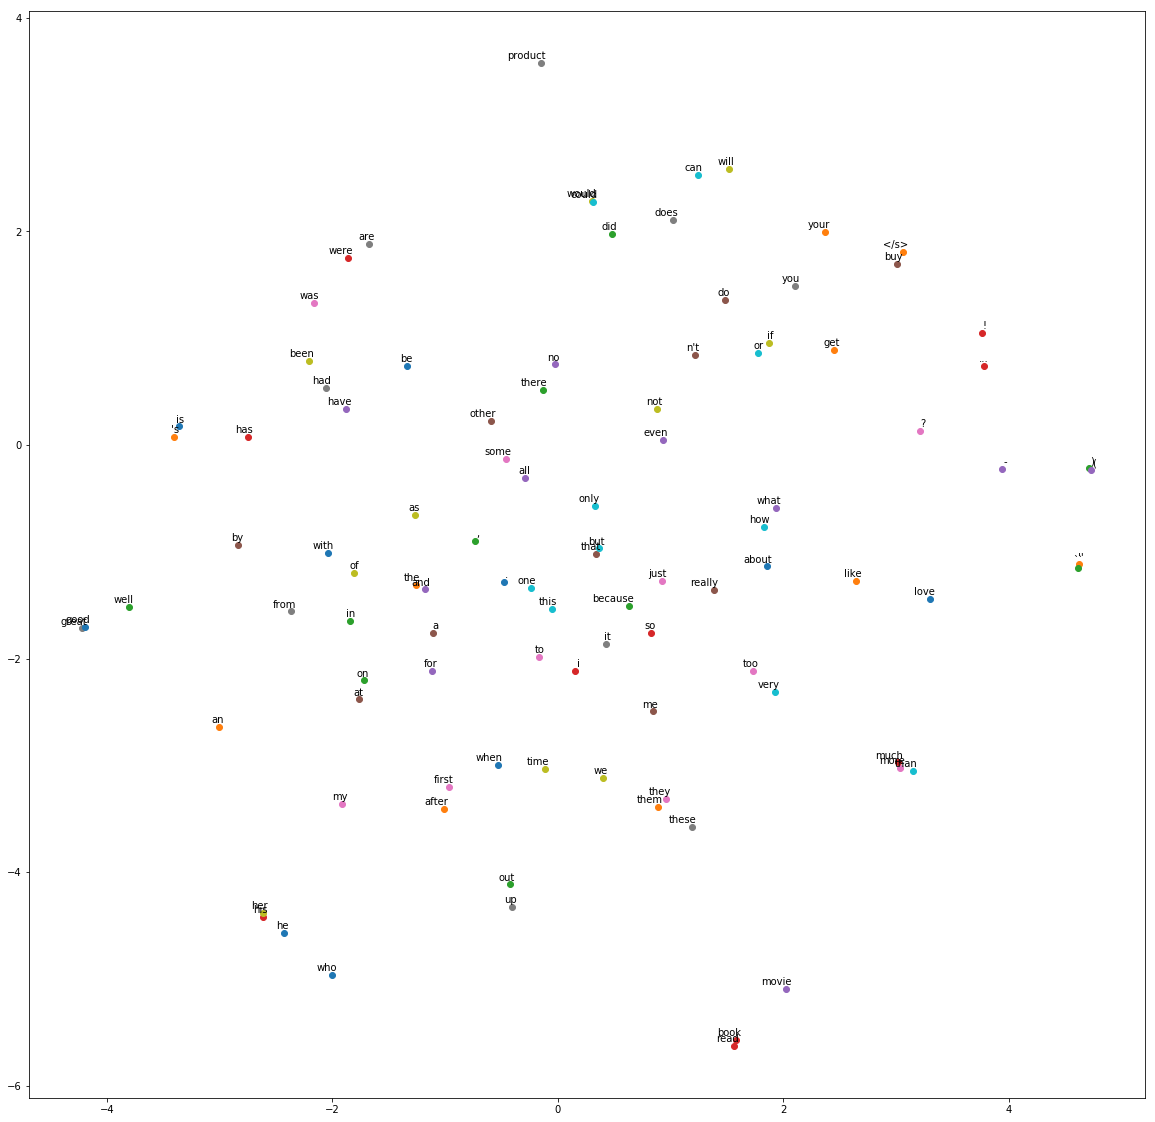

In [52]:
from matplotlib import pylab
%matplotlib inline

def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embeddings, labels)

## convert sentence to features using word2vec

In [77]:
vector_file = 'vectors.txt'
with open(vector_file, 'r') as csvinfile:
    word2vec = dict()
    csv_reader = csv.reader(csvinfile, delimiter=' ')
    for row in csv_reader:
        word2vec[row[0]] = row[1:101]
        

In [101]:
def add_word2vec_instance(row):
    cur_row = []
    vec = np.zeros(100)
    cur_row.extend(nltk.word_tokenize(row[1].lower()))
    cur_row.extend(nltk.word_tokenize(row[2].lower()))
    sentence_len = 1
    for word in cur_row:
        if word in word2vec:
            vec += np.array(word2vec[word], dtype=np.float32)
            sentence_len += 1    
    return vec/sentence_len

In [102]:
def convert_sentence_to_vector(input_file, output_file):
    all_rows = []
    with open(input_file, 'r') as csvinfile:
        csv_reader = csv.reader(csvinfile, delimiter=',')
        for row in csv_reader:
            all_rows.append(row)
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(add_word2vec_instance, all_rows)
    pool.close() 
    pool.join()
    
    with open(output_file, 'w') as csvoutfile:
        csv_writer = csv.writer(csvoutfile, delimiter=',', lineterminator='\n')
        csv_writer.writerows(transformed_rows)

In [ ]:
%%timeit
# Preparing the training dataset

# Since preprocessing the whole dataset might take a couple of mintutes,
#  
#  
convert_sentence_to_vector('/home/ec2-user/SageMaker/amazon_review_polarity_csv/train.csv', 'polarity_vector.train')
convert_sentence_to_vector('/home/ec2-user/SageMaker/amazon_review_polarity_csv/test.csv', 'polarity_vector.validation')
       

In [114]:
!wc -l polarity_vector.train

3600000 polarity_vector.train


In [117]:
!head polarity_vector.train

-0.01986848025820976,-0.9525619758682888,-0.6567663959942238,-0.7029325767355257,0.7726962585435357,-1.755823449177876,0.012351055607892746,0.27310572980448256,0.13439852371811867,0.13084629459068353,0.43874440011893245,-0.44157618493773043,0.6891145575358424,0.48157938936898526,-0.3940637894299661,0.38722711202802224,0.11578346108801144,-0.13006307135422734,0.07756642762268352,0.22405431752071478,0.3438883690748277,0.3706046217662651,-0.14619858977760508,0.4599467139084672,-0.6042892898914816,0.7075210591388303,0.06259237496225639,0.08006614866818107,-0.42248387500470463,-0.24475980086284582,-0.8316517649001853,0.19525383531960638,0.39118697917153844,-0.5193348352385815,0.32002225700159403,-0.26659939481421957,-0.08371829160294214,0.41837403296796216,0.12953811831945597,0.23368311969585023,-0.20951307649442621,0.7615195514720886,-0.05736355780255656,-0.2897792880661612,-0.6481230880545322,0.42137311463958993,-0.41427223739582436,-0.01965296953959867,0.2833043704199236,0.67231586874397

### save to s3

In [115]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path='polarity_vector.train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='polarity_vector.validation', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

CPU times: user 1min 3s, sys: 17 s, total: 1min 20s
Wall time: 39 s


## K mean

In [ ]:
# https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/US-census_population_segmentation_PCA_Kmeans/sagemaker-countycensusclustering.ipynb

In [123]:
from sagemaker import KMeans

num_clusters = 2
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=s3_output_location,              
                k=num_clusters)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-023375022819


In [134]:
train_data = pd.read_csv('polarity_vector.train', header=None).values.astype('float32')  # load training data vectors

In [130]:
train_v.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.019868,-0.952562,-0.656766,-0.702933,0.772696,-1.755823,0.012351,0.273106,0.134399,0.130846,...,0.068868,-0.822019,-0.892953,0.977425,0.055623,-0.091883,0.394958,-0.026713,-0.286480,0.251654
1,0.010652,-0.967484,-0.502486,-0.944999,1.125768,-1.767978,0.302243,0.263129,0.096815,-0.167182,...,-0.141663,-0.807785,-1.233959,0.787909,0.200420,-0.364891,0.756804,0.268524,-0.302454,0.267107
2,-0.177871,-1.026890,-0.366287,-0.808034,1.030785,-1.474581,0.147506,0.439819,0.132606,-0.082712,...,-0.157293,-0.955032,-1.090675,0.756312,0.346141,-0.260926,0.504809,0.343746,-0.047538,0.396654
3,-0.321089,-0.853429,-0.301999,-0.874177,0.691663,-1.315418,0.118468,0.657686,0.108578,0.238123,...,-0.027240,-0.925951,-0.830659,0.726219,0.304144,-0.186678,0.493317,0.148684,-0.105066,0.156624
4,-0.024705,-1.063070,-0.442137,-1.019380,0.764115,-1.615800,0.133004,0.437945,0.113544,-0.168202,...,-0.339740,-0.745534,-0.974529,0.822893,0.385625,-0.111247,0.365775,0.138066,-0.088834,0.281332


In [131]:
#train_data = train_v.values.astype('float32')


In [135]:
%%time
kmeans.fit(kmeans.record_set(train_data))

INFO:sagemaker:Creating training-job with name: kmeans-2019-03-14-14-07-37-442


2019-03-14 14:07:37 Starting - Starting the training job...
2019-03-14 14:07:39 Starting - Launching requested ML instances......
2019-03-14 14:08:49 Starting - Preparing the instances for training......
2019-03-14 14:10:07 Downloading - Downloading input data...
2019-03-14 14:10:38 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[03/14/2019 14:10:40 INFO 140223307892544] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]


2019-03-14 14:11:01 Uploading - Uploading generated training model
2019-03-14 14:11:01 Completed - Training job completed
Billable seconds: 55
CPU times: user 2min 35s, sys: 7.44 s, total: 2min 42s
Wall time: 6min 25s


In [142]:
%%time
# send original training set and get positive/negative review labels
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

INFO:sagemaker:Creating model with name: kmeans-2019-03-14-14-31-49-721
INFO:sagemaker:Creating endpoint with name kmeans-2019-03-14-14-07-37-442


---------------------------------------------------------------------------------------!CPU times: user 3.22 s, sys: 3.47 s, total: 6.69 s
Wall time: 7min 21s


In [146]:
train_data[:1000,:]

array([[-0.01986848, -0.952562  , -0.6567664 , ..., -0.02671252,
        -0.28648046,  0.25165424],
       [ 0.01065152, -0.9674835 , -0.50248563, ...,  0.2685237 ,
        -0.30245423,  0.26710665],
       [-0.17787108, -1.02689   , -0.3662867 , ...,  0.34374633,
        -0.04753788,  0.39665374],
       ...,
       [-0.33110967, -0.66746557, -0.40593022, ...,  0.24333486,
        -0.8377356 ,  0.2884604 ],
       [-0.09668317, -0.64469254, -0.5466572 , ...,  0.20718008,
        -0.65594685,  0.32255456],
       [-0.24755973, -0.87659824, -0.34699205, ...,  0.36552447,
        -0.3719855 ,  0.22197278]], dtype=float32)

In [169]:
%%time
result=kmeans_predictor.predict(train_data[:10000,:])  ## limit the size else you will get error. 

CPU times: user 888 ms, sys: 7.63 ms, total: 896 ms
Wall time: 1.53 s


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


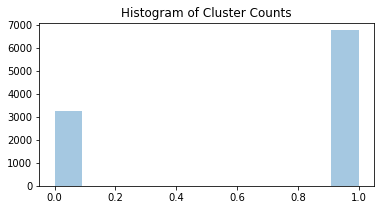

In [159]:
# breakdown of cluster counts and distribution of clusters
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_labels)[0].value_counts()
ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [160]:
# read test data
test_data = pd.read_csv('polarity_vector.validation', header=None, nrows=10000).values.astype('float32')  # load training data vectors

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


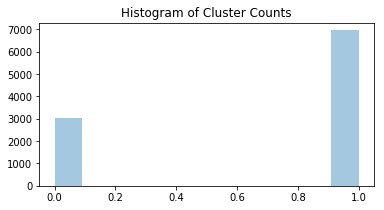

CPU times: user 1.15 s, sys: 187 ms, total: 1.33 s
Wall time: 1.76 s


In [221]:
%%time
result=kmeans_predictor.predict(test_data)  ## limit the size else you will get error. 
# breakdown of cluster counts and distribution of clusters
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_labels)[0].value_counts()
ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [222]:
# test single line
result=kmeans_predictor.predict(test_data[0,:])  ## limit the size else you will get error. 
# breakdown of cluster counts and distribution of clusters
cluster_label = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_label)[0].value_counts()

1.0    1
Name: 0, dtype: int64

In [177]:
# read original test file
test_data_original = pd.read_csv('/home/ec2-user/SageMaker/amazon_review_polarity_csv/test.csv', header=None, nrows=10000)

In [211]:
test_data_original.columns=['label','title','review']

In [227]:
test_data_original.label = test_data_original.label - 1

In [228]:
test_data_original.label.value_counts()

1    5125
0    4875
Name: label, dtype: int64

In [236]:
cluster_labels = [int(i) for i in cluster_labels]

In [237]:
pd.DataFrame(cluster_labels)[0].value_counts()

1    6950
0    3050
Name: 0, dtype: int64

In [244]:
from sklearn.metrics import confusion_matrix, classification_report
print(pd.crosstab(test_data_original.label, pd.DataFrame(cluster_labels)[0], \
                  rownames=['Actual'], colnames=['Predicted']))
print(classification_report(test_data_original.label, pd.DataFrame(cluster_labels)[0]))
 

Predicted     0     1
Actual               
0          1687  3188
1          1363  3762
             precision    recall  f1-score   support

          0       0.55      0.35      0.43      4875
          1       0.54      0.73      0.62      5125

avg / total       0.55      0.54      0.53     10000

